<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Deep-Learning project</h1></center>
<center><h2>Age and gender detection</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


We will work with the dataset **```age_gender.csv```**. This dataset contains images of faces, as well as the gender and age of the person in question.

> The structure of the exercise is as follows: 
>> I - [Preparation of the dataset](#preparation)
>>
>>
>> II - [Gender classification and age prediction](#model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# I - <a name="preparation"></a> Preparation of the dataset

In [2]:
df = pd.read_csv("age_gender.csv", sep=",")
df["pixels"] = df["pixels"].apply(lambda x : np.array(x.split()).astype(np.int16).reshape(48, 48, 1))

In [3]:
print("Number of rows in the dataset : {}".format(df.shape[0]))
print("Number of columns in the dataset : {}".format(df.shape[1]))

df.head()

Number of rows in the dataset : 23705
Number of columns in the dataset : 5


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[[[129], [128], [128], [126], [127], [130], [1..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[[[164], [74], [111], [168], [169], [171], [17..."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[[[67], [70], [71], [70], [69], [67], [70], [7..."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[[[193], [197], [198], [200], [199], [200], [2..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[[[202], [205], [209], [210], [209], [209], [2..."


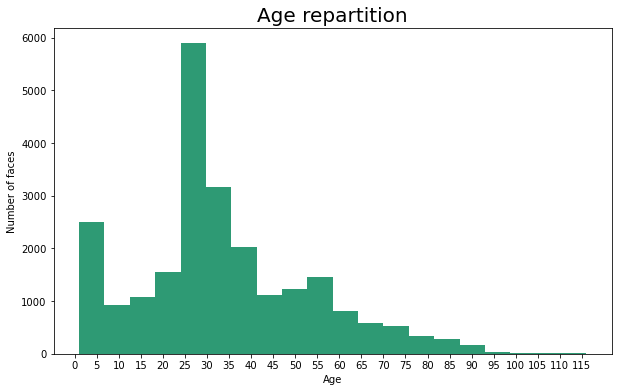

In [4]:
plt.figure(figsize=(10, 6))

df["age"].hist(bins=20, grid=False, color="#2e9a74")
plt.title("Age repartition", fontsize=20)
plt.xlabel("Age")
plt.ylabel("Number of faces")
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115]);

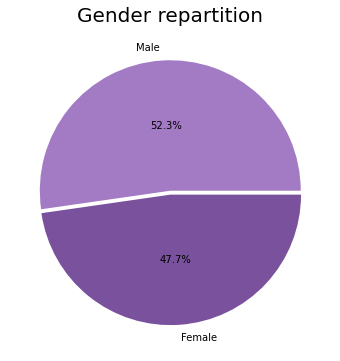

In [5]:
plt.figure(figsize=(6, 6))

plt.pie(x=df["gender"].value_counts().values, 
        autopct="%.1f%%", 
        labels=["Male", "Female"], 
        pctdistance=0.5,
        colors=["#a37bc4", "#79519c"],
        explode=[0, 0.03])
plt.title("Gender repartition", fontsize=20);

In [6]:
df = df[df["age"]>=15].reset_index(drop=True)

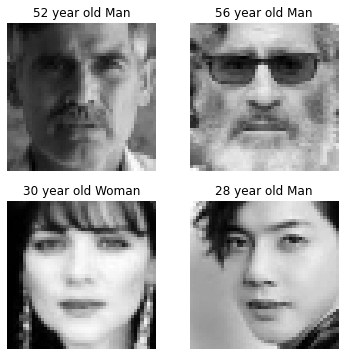

In [7]:
gender_dict = {0 : "Man", 1 : "Woman"}
age_max = df["age"].max()

fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for row in range(2):
  for col in range(2):
    i = np.random.randint(len(df))
    axs[row, col].imshow(df["pixels"].iloc[i].reshape((48, 48)), cmap="gray")
    axs[row, col].axis("off")
    axs[row, col].set_title("{} year old {}".format(df["age"].iloc[i], gender_dict[df["gender"].iloc[i]]))

# II - <a name="model"></a> Gender classification and age prediction

In [9]:
class DataGenerator():
    def __init__(self, df):
        self.df = df        


    def generate_splits(self):     
        """reproduction of the train_test_split function"""                           
        permut = np.random.permutation(len(self.df))          # shuffle of indices

        # equivalent of data_without_test, data_test = train_test_split(data, test_size=0.2)
        train_up_to = int(len(self.df)*0.8)
        indices_without_test = permut[:train_up_to]           
        test_indices = permut[train_up_to:]              
        
        # equivalent of data_train, data_validation = train_test_split(data_without_test, test_size=0.2)
        train_up_to = int(train_up_to*0.8)
        train_indices = indices_without_test[:train_up_to]
        valid_indices = indices_without_test[train_up_to:] 

        return train_indices, valid_indices, test_indices     # return the indices


    def generate_images(self, indices, is_training, batch_size=32):  
        """used to generate batches with images during training/testing/validation of our Keras model
           for example, we will have "indices=train_indices, is_training=True" for a training generator
                                "indices=test_indices, is_training=False" for a test generator"""
        max_age = self.df['age'].max()                                           # max_age is used to scale the ages between 0 and 1
        files, genders, ages = [], [], []                                        # we initialize empty lists to contain what the generator will return
        while True:
            for i in indices:                                                    # we browse the indices of the list taken in argument
                person = self.df.iloc[i]                                         # we locate the person of index i

                files.append((person['pixels']/255))                             # we add the image of the person of index i (pixels scaled between 0 and 1)
                genders.append(person['gender'])                                 # we add the gender of the person of index i
                ages.append(person['age']/max_age)                               # we add the scaled age of the person of index i

                if len(files) >= batch_size:                                     # as soon as the desired batch size is reached
                    yield np.array(files), [np.array(genders), np.array(ages)]   # we return the data
                    # make sure you remember the order of the outputs as we will have to define our model accordingly
                    files, genders, ages = [], [], []                            # we reset the lists
            # for predictions, you have to stop after going through all the data once
            if not is_training:
                break

In [10]:
data_generator = DataGenerator(df)
train_indices, valid_indices, test_indices = data_generator.generate_splits() 

In [11]:
batch_size = 64

training_data = data_generator.generate_images(train_indices, is_training=True, batch_size=batch_size)
valid_data = data_generator.generate_images(valid_indices, is_training=True, batch_size=batch_size)
test_data = data_generator.generate_images(test_indices, is_training=False, batch_size=batch_size)

In [12]:
class MultiOutputModel():
    def hidden_layers(self, inputs):
        x = Conv2D(filters=30, kernel_size=(5, 5), padding="valid", activation="relu")(inputs)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Conv2D(filters=32, kernel_size=(3, 3), padding="valid", activation="relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(rate=0.25)(x)
        return x
    def gender_branch(self, inputs):
        x = self.hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(units=64, activation="relu")(x)
        x = Dropout(rate=0.2)(x)
        x = Dense(units=1, activation="sigmoid", name="gender_output")(x)
        return x
    def age_branch(self, inputs):   
        x = self.hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(units=64, activation="relu")(x)
        x = Dropout(rate=0.2)(x)
        x = Dense(units=1, activation="linear", name="age_output")(x)
        return x
    def create_model(self, input_shape):
        inputs = Input(shape=input_shape)
        gender_branch = self.gender_branch(inputs)
        age_branch = self.age_branch(inputs)
        model = Model(inputs=inputs, outputs=[gender_branch, age_branch])
        return model
        
input_shape = (48,48,1)
model = MultiOutputModel().create_model(input_shape)

In [13]:
early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         patience=8,
                                         mode="min",
                                         restore_best_weights=True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                         patience=5,
                                         factor=0.5,
                                         verbose=2,
                                         mode="min")

In [14]:
loss = {"gender_output": "binary_crossentropy", "age_output": "mse"}
metrics = {"gender_output": "accuracy", "age_output": "mse"}

model.compile(optimizer="adam", loss=loss, metrics=metrics)

In [15]:
history = model.fit(training_data,
                    steps_per_epoch=len(train_indices)//batch_size,
                    epochs=100,
                    validation_data=valid_data,
                    validation_steps=len(valid_indices)//batch_size,
                    callbacks=[early_stopping, lr_plateau])

Epoch 1/100
200/200 [==============================] - 7s 24ms/step - loss: 0.5077 - gender_output_loss: 0.4852 - age_output_loss: 0.0225 - gender_output_accuracy: 0.7604 - age_output_mse: 0.0225 - val_loss: 0.3511 - val_gender_output_loss: 0.3364 - val_age_output_loss: 0.0146 - val_gender_output_accuracy: 0.8647 - val_age_output_mse: 0.0146 - lr: 0.0010
Epoch 2/100
200/200 [==============================] - 5s 23ms/step - loss: 0.3360 - gender_output_loss: 0.3212 - age_output_loss: 0.0148 - gender_output_accuracy: 0.8691 - age_output_mse: 0.0148 - val_loss: 0.2988 - val_gender_output_loss: 0.2875 - val_age_output_loss: 0.0113 - val_gender_output_accuracy: 0.8897 - val_age_output_mse: 0.0113 - lr: 0.0010
Epoch 3/100
200/200 [==============================] - 5s 23ms/step - loss: 0.2895 - gender_output_loss: 0.2766 - age_output_loss: 0.0129 - gender_output_accuracy: 0.8888 - age_output_mse: 0.0129 - val_loss: 0.2728 - val_gender_output_loss: 0.2618 - val_age_output_loss: 0.0110 - val_ge

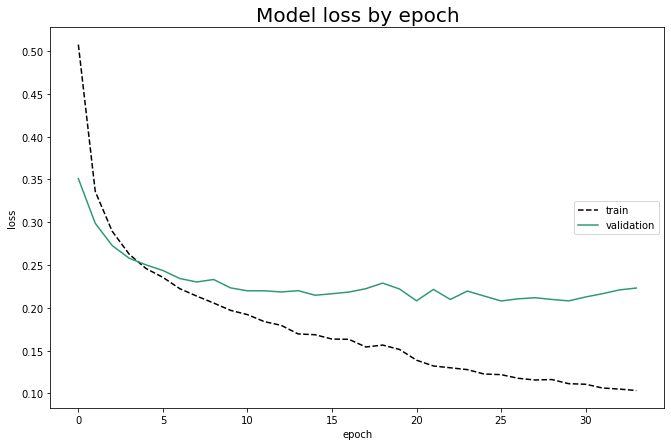

In [16]:
plt.figure(figsize=(11, 7))

plt.plot(history.history["loss"], "k--")
plt.plot(history.history["val_loss"], color="#2e9a74")
plt.title("Model loss by epoch", fontsize=20)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="right");

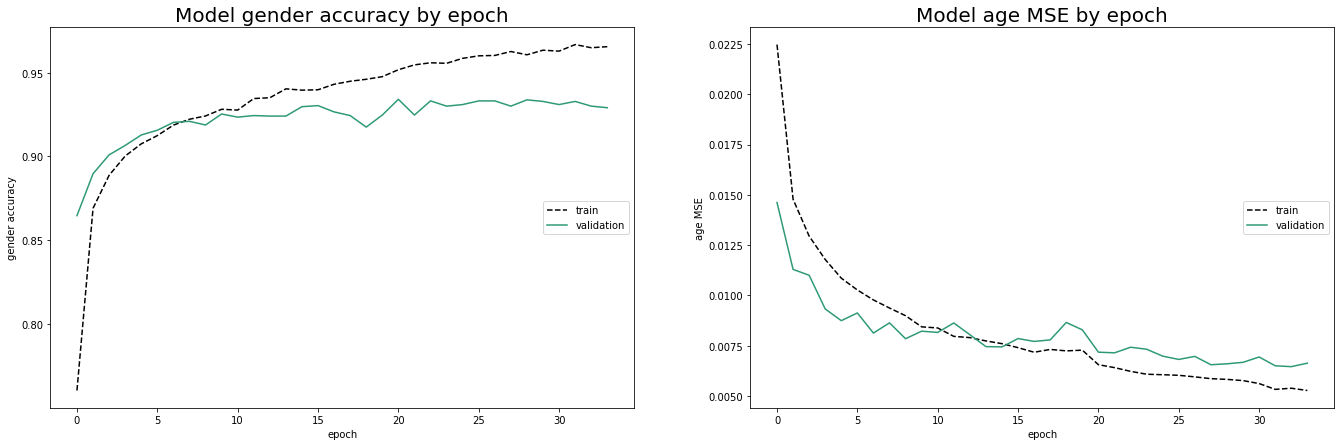

In [17]:
plt.figure(figsize=(23, 7))

plt.subplot(121)
plt.plot(history.history["gender_output_accuracy"], "k--")
plt.plot(history.history["val_gender_output_accuracy"], color="#2e9a74")
plt.title("Model gender accuracy by epoch", fontsize=20)
plt.ylabel("gender accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="right")

plt.subplot(122)
plt.plot(history.history["age_output_mse"], "k--")
plt.plot(history.history["val_age_output_mse"], color="#2e9a74")
plt.title("Model age MSE by epoch", fontsize=20)
plt.ylabel("age MSE")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="right");

In [18]:
model.evaluate(test_data)

62/62 [==============================] - 1s 22ms/step - loss: 0.1980 - gender_output_loss: 0.1913 - age_output_loss: 0.0068 - gender_output_accuracy: 0.9395 - age_output_mse: 0.0068


[0.19802027940750122,
 0.19125492870807648,
 0.006765374913811684,
 0.9395161271095276,
 0.006765374913811684]

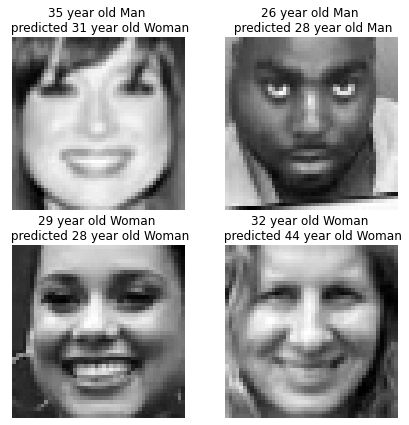

In [19]:
gender_dict = {0 : "Man", 1 : "Woman"}
age_max = df["age"].max()

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

for row in range(2):
    for col in range(2):
        i = np.random.randint(len(test_indices))
        pred = model.predict((df["pixels"][test_indices[i]]/255).reshape(1, 48, 48, 1))
        axs[row, col].imshow(df["pixels"][test_indices[i]].reshape((48, 48)), cmap="gray")
        axs[row, col].axis("off")
        axs[row, col].set_title("{} year old {} \n predicted {} year old {}"\
                            .format(df["age"][test_indices[i]], gender_dict[df["gender"][test_indices[i]]],\
                                    max(int(round(pred[1][0][0]*age_max)), 0), gender_dict[pred[0][0][0].round()]))

In [20]:
model.save("age_gender_detector.h5")